# Recommender System using Embeddings

In second week of inzva Applied AI program, we are going to create a Recommender System which uses product descriptions to find similarities between them. Our purpose will be using a technique that can maps text based description to a numerical vector so that we can find similarities between them. For such a task, embeddings work perfectly.

As an embedding technique, we will use Word2Vec. 

## Libraries for this notebook

Other then libraries such as pandas, numpy, matplotlib we will use gensim and tqdm libraries in this notebook. It is worth to mention about them.

### Gensim Library

Gensim is a topic modelling library for Python that provides access to Word2Vec and other word embedding algorithms for training, and it also allows pre-trained word embeddings that you can download from the internet to be loaded. Gensim provides a number of helper functions to interact with word vector models. Similarity is determined using the cosine distance between two vectors. 

- (https://pypi.org/project/gensim/)
- (https://en.wikipedia.org/wiki/Topic_model)

### Tqdm Library

tqdm derives from the Arabic word taqaddum (تقدّم) which can mean “progress,” and is an abbreviation for “I love you so much” in Spanish (te quiero demasiado).
Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable).
(https://pypi.org/project/tqdm/)


In [101]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

## Our Data

In [102]:
df = pd.read_excel('/Users/Scoutium/Desktop/inzva/Online Retail.xlsx')

In [130]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
df.shape

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We simply remove missing values. We already have a good amount of data that is enough to create a model.

In [106]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Number of unique customers.

In [107]:
df['StockCode']= df['StockCode'].astype(str)

customers = df["CustomerID"].unique().tolist()
len(customers)

4372

Train - Validation set split.

In [108]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [109]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    print(temp)
    purchases_train.append(temp)

  4%|▍         | 158/3935 [00:00<00:05, 740.47it/s]

['22727', '22725', '22726', '22960', '22568', '22570', '20971', '22750', '21912', '21914', '22264', '22725', '22729', '22728', '23126', '23128', '23177', '21746', '21915', '21914', '20971', '22727', '22729', '22726', '22730', '22910', '22086', '23311', '22960', '22966', '21915', '21914', '23077', '23083', '23082', '22466']
['84212', '22469', '21232', '85123A', '84946', '22220', '72760B', '22423', '22776', '23371', '23372', '23404', '23401', '23403', '23427', '23503', '21485', '22112', '22114', '22111', '22835', '23355', '23283']
['20837', '21621', '47566', '47341A', '22423', '22178', '21629', '82484']
['23212', '22507', '23298', '23144', '84970S', '21756', '21755', '22120', '22082', '22080', '22118', '23419', '22695', '22603', '22338', '23213', '23265', '21136', '23275', '22575', '23213', '22603', '23189', '22508', '21116', '21411', '22594', '22696', '23213', '23212', '23265', '22603', '22600', '22338', '23222', '23275', '21755']
['48111', '82484', '22296', '22183', '79164', '84683', '

  9%|▉         | 349/3935 [00:00<00:04, 837.43it/s]

['21584', '22704', '22710', '22711', '21495', '22045', '22536', '22531', '22619', '21889', '22988', '21918', '22548', '21830', '21731', '21504', '22716', '21507', '21509', '21508', '22616', '22564', '22563', '22562', '21790', '22556', '22555', '21791', '22549', '20750', '20963', '20966', '21915', '21914', '22198', '22197', '22618', '22758', '22753', '22713', '22659', '85099B', '20713', '22659', '22629', '84988', '22417', '22951', '22570', '22900', '22992', '85199L', '21563', '22252', '21731', '85227', '22437', '22435', '22525', '22520', '22522', '22521', '22523', '22385', '22716', '23230', '22745', '22746', '22748', '22747', '22980', '84199', '22332', '21725', '21724', '21720', '21723', '84559B', '84559A', '22524', '22971', '22988', '22659', '22526', '22693', '84077', '22519', '22517', '22517', '22515', '22514', '22432', '22433', '22431', '22967', '22148', '22631', '22502', '21832', '21746', '20749', '20750', '21749', '22264', '20712', '85099B', '22630', '22713', '22474', '23006', '229

 11%|█         | 442/3935 [00:00<00:04, 861.81it/s]

['21071', '20971', '23319', '22505', '21932', '22435', '23522', '23521', '21901', '35970', '22197', '23539', '21899', '22553', '22557', '11001', '23103', '21463', '23287', '23285', '20727', '23209', '11001', '23158', '22960', '21071', '21704', '22086', '35970', '84596B', '20718', '23298', '21907', '20727', '22383', '21592', '22961', '21213', '23461', '22607', '23319', '23412', '21371', '21374', '23540', '21901', '22720', '22633', '22865', '22554', '22553', '22435', '21891', '23215', '22439', '23263', '84879', '22564', '23298', '23284', '21055', '21071', '84596B', '84596F', '22965', '23339', '21249', '23344', '23319']
['84352', '23203', '22505', '22968', '84879', '22149', '47566', '22433', '22138', '22139', '20981', '22111', '22835', '22355', '21931', '21929']
['85150', '21757', '21171', '82599', '85152', '82600', '85174', '21713', '22115', '22413', '21908', '21174', '21166', '85173', '71053', '82552', '22457', '72741', '22456', '84406B', '84792', '20675', '21232', '22767', '22625', '21

 15%|█▌        | 592/3935 [00:00<00:05, 662.54it/s]

['23127', '23126', '22940', '22750', '22749', '22273', '22271', '22147', '20971', '20970']
['47504K', '22508', '35646', '35648', '21498', '85039A', '21980']
['23330', '23333', '22909', '22952', '21790', '22582', '22865', '22866', '22632', '22633', '84992', '85048', '23268', '23266', '23265', '23264', '23263', '23221', '23223', '23220', '23222', '22581', '22579', '22578', '22577', '22595', '22594', '22593']
['22468', '22780', '22112', '22720', '21217', '22840', '22841', '21033', '85123A', '21181', '21843', '22698', '22699', '22423', '22697', '85099B', '21931', '22383', '22411', '22585', '22779', '22348', '21212', '22073', '21539', '37370', '21870', '21914', '21259', '22892', '21181', '85123A', '21843', '22139', '22779', '21844', '22780', '21284', '21066', '21259', '21175', '82484', '21866', '22561', '21731', '84991', '21928', '85150', '85099C', '85099F', '20713', '21930', '84946', '21915', '84375', '21975', '84992', '84978', '22457', '47566', '21232', '22178', '21314', '21985', '22721',

 19%|█▉        | 761/3935 [00:00<00:04, 745.63it/s]

['22998', '84625A', '47503A', '22244', '22196', '22195', '21563', '21564', '22399', '22396', '22398', '23155', '23154', '22922', '23159', '16219', '21179', '21367', '21368', '85116', '85212', '22139', '22138', '22617', '22593', '23268', '22131', '22750', '21136', '84879', '23433', '23400', '23206', '85015', '23280', '23000', '22996', '23004', '21892', '23399', '84879', '20725', '20727', '22383', '22595', '22593', '22023', '22115', '22358', '23348', '22619', '23431', '23432', '22318', '22923', '22924', '23155', '84929', '22651', '85176', '85178', '84665', '22138', '22340', '22139', '23503', '23508', '21509', '22817', '22998', '22999', '22383', '23206', '20725', '20914', '22027', '21136', '84879', '22212', '23348', '85123A', '22139', '21136', '84879', '22329', '22131', '22340', '22383', '22384', '23206', '23534', '22969', '21108', '16048', '16045', '22400', '22402', '22403', '90058B', '21948', '21949', '22115', '22619', '22138', '22817', '22662', '23503', '20914', '23508', '85071C', '232

 21%|██▏       | 837/3935 [00:01<00:04, 624.15it/s]

['23130', '23129', '22952', '23340', '22950', '23376', '23314', '23318', '22734', '85049A', '23349', '22910', '23234', '23157', '22941', '23294', '23293', '23295', '23296', '22839', '22841', '22197', '22960', '23312', '22739', '22737', '22738']
['22470', '84880', '23298', '22501', '22197', '22434', '21624', '22469', '23192', '22367', '21156', '21625', '22317', '22318', '47574A', '84510A', '22776', '22557', '22556', '22551', '22032', '22993', '21217', '20992', '82482', '22979', '21411', '84509A', '20751', '85062', '21947', '22980', '21407', '22814', '22031', '22037', '21519', '22716', '22714', '22291', '21385', '22293', '84836', '21385', '22156', '85123A', '22033', '21626', '85062', '48187', '48138', '21713', '21755', '21756', '21754', '22969', '22178', '22693', '22487', '23077', '23065', '21756', '72741', '22197', '85034A', '85035A', '85040A', '22464', '72122', '85123A', '22178', '22156']
['21925', '21926', '21927', '46000S', '22498', '22499', '20761', '20766', '22023', '82482', '22497

 24%|██▍       | 963/3935 [00:01<00:05, 541.10it/s]

['23051', '23052', '23050', '23053', '21922', '22970', '22971', '22084', '22911', '21199', '21212', '21470', '21469', '21468', '21465', '21088', '21557', '21973', '22949', '21975', '22951', '21212', '22302', '22303', '21199', '21096', '21034', '22499', '22089', '22084', '21878', '22139', '21559', '21561', '22083', '21557', '22197', '22501']
['22844', '21841', '84580', '84581', '84032A', '84032B', '22481', '22210', '22209', '22209', '22208', '72802C', '23369', '22139', '23335', '23366', '23368', '23367', '85034A', '20748', '85150', '82582', '85152', '21165', '82552', '82551', '21172', '23426', '22413', '22412', '21908', '21905', '21181', '22672', '22210', '22211', '22208', '23420', '21587', '22568', '23420', '21710', '21816', '21709', '22937', '21707', '21706', '15056N', '22980', '22993', '22907', '22982', '22981', '22982', '21816', '21815', '16238', '21698', '23158', '23159', '23154', '23156', '22403', '23337', '23336', '23156', '23131', '23421', '22950', '22671', '23335', '23422', '22

 29%|██▉       | 1148/3935 [00:01<00:04, 687.06it/s]

['23469', '23470', '84884A', '22187', '23466', '22201', '22928', '85034C', '21317', '21754', '23479', '23461', '23300', '23301', '23130', '23129', '23131', '23321', '23169', '23322', '22470', '21914', '15039', '23570', '85227', '21544', '20975', '22771', '21080', '21592', '15034', '22151', '21427', '21327', '20752', '21705', '22961', '21947', '47503A', '23196', '23570', '22885', '21744', '23102', '84951B', '21947', '23206', '23198', '21791', '16225', '21588', '20982', '23107', '23208']
['90160A', '90160D', '90160B', '90160C', '90161B', '90161C', '90161D', '90201B', '90201D', '90201A', '90201C', '17003', '22512', '22513', '90030B', '90030A', '90031', '90030C', 'POST', '90201A', '90160A']
['22826', '23200', '23199', '85099B', '21115', '21624', '20749']
['23301', '22086', '23319', '22910', '22909', '23267', '22950', '23318', '22952', '22737', '22960', '23154', '23120', '22439', '22436', '23119', '23319', '23318', '23301', '23267', '23154', '23120', '23119', '22960', '22952', '22950', '229

 34%|███▍      | 1340/3935 [00:01<00:03, 802.56it/s]

['21733', '48184', '20685', '21523', '20914', '21527', '21071', '21069', '79000', '22892', '22131', '22895', '22897', '22558', '21843', '21154', '22819', '22030', '22040', '22986', '21498', '22837', '22113', '22111', '22112', '22652', '47580', '47559B', '22073', '22113', '22111', '22112', '22837', '21479', '21870', '22652', '22358', '21868', '37370', '22807', '22297', '84836', '22312', '22856', '21181', '21907', '22775', '84050', '22459', '22458', '22358', '22358', '22851', '21498', '16156S', '22698', '22697', '22112', '22411', '20717', '85099F', '22419', '22421', '47567B', '47559B', '47566', '21080', '85099B', '21843', '21531', '21535', '22982', '22978', '22720', '22722', '22965', '22966', '84378', '21877', '84050', '21071', '21069', '21210', '22892', '22178', '71459', '22804', '21733', '85123A', '71053', '22807', '21876', '47567B', '22892', '17011F', '21398', '21399', '21845', '21530', '35809A', '35810A', '79331', '84877A', '84875D', '22499', '47566B', '22212', '82483', '82486', '851

 36%|███▋      | 1427/3935 [00:01<00:03, 739.31it/s]

['21175', '84380', '84378', '84879', '21166', '23156', '23154', '21977', '22637', '22432', '22433', '47566B', '47566', '23298', '84991', '85123A', '84970S', '84836', '21868', '21389', '21386', '21385', '21136', '84879', '23154', '23156', '47566B', '47566', '23298', '84836', '85123A', '23298', '84836', '47566', '21535', '47566B', '84879', '21535']
['23284', '21955', '48138', '20679', '15056N', '84708B', '21756', '21755', '21754', '47566', '47566B', '22170', '71038', '84792', '37413', '82552', '22066', '82494L', '82482', '72351A', '72351B', '84792', '72780', '22217', '22998', '22996', '23003', '22997', '21135', '51014L', '21034', '22095']
['21581', '22619', '84997B', '20727', '20726', '22383', '21249', '22378', '22175', '22176', '84997C', '20728', '22382', '21915', '22549', '21578', '21577', '22245', '22244', '22449', '22450', '22451', '22993', '22449', '20726', '20725', '20727', '22383', '22384', '22662', '22333', '84997B', '22273', '22382', '22379', '22138', '22617', '22195', '22380', 

 40%|████      | 1586/3935 [00:02<00:03, 745.18it/s]

['20996', '21992', '22209', '22610', '84665', '85032B', '85071C', '22716', '22028', '22029', '22712', '22983', '84251G', '20982', '23191', '23192', '22652', '22621', '22557', '23240', '16218', '22277', '23408', '21108', '22717', '22718', '22595', '22961', '20981', '22652', '22557', '23240', 'POST', '23408', '22423', '35953', '23569', '23228', '20668', '23213', '22966', '84380', '21977', '22955', '22196', '22609', '22422', '23240', '23210', '22636', '21914', '21892', '23367', '23368']
['85123A', '21733', '71477', '71477', '21733', '85123A', '71477', '71477', '71477', '84356', '84347', '72799E', '72799C', '72800E', '72800C', '72800B', '71477', '23320']
['20961', '21317', '85127', '21324', '22784', '71053', '21730', '22178', '85123A', '21313', '22105', '22103', '22791', '84945', '84946', '48138', '48111', '22508', '21114', '22061', '22890', '22423', '37449', '37446', '21231', '21232', '22063', '37450', '22057', '37447', '21078', '22180', '84212', '21927', '22645', '21472', '47559B', '2121

 45%|████▍     | 1756/3935 [00:02<00:02, 792.52it/s]

['23493', '23434', '84875B', '90030A', '90030B', '23076', '22138', '21116', '21934', '21494', '21935', '22110', '22821', '79144B', '22944']
['23198', '23245', '23295', '23293', '23296', '23307', '23297', '23308', '23319', '84945', '22961', '22962', '22169', '23298', '22989', '22720', '22979', '22980', '84380', '23119', '22423', '23255', '23254', '23256', '23240', '21121', '23167', '21880', '22558', '22094', '22752']
['22633', '22632', '22867', '22865', '22086', '85123A', '22083', '22759', '21677', '22168', '22113', '84978', '22558', '22163', '22164', '85123A', '22297', '22084', '85123A', '84380', '22082', '22084', '22113', '84378', '22750', '22274', '22749', '22568', '22185', '85123A', '22986', '22050', '20829', '84226', '21454', '21617', '21454', '22452', '22454', '22445', '22445', '20829', '21454', '21455', '21293', '84792', '22912', '22504', '22070', '22071', '21306', '21034', '22838', '21620', '21001', '84946', '20763', '20762', '20765', '20761', '20766', '20764', '84985A', '22445'

 49%|████▉     | 1936/3935 [00:02<00:02, 823.16it/s]

['22161', '84944', '85130B', '22577', '22578', '22579', '22694', '23268', '22141', '22144', '22142', '85061W', '22576', '85199S', '23269', '22158', '22154', '23275']
['47503J', '48184', '48187', '22846', '21913', '22278', '22467', '22956', '37464', '22956', '85014B', '84247N', '84247K', '22029', '22035', '22943', '22469', '21250', '21678', '22435', '84569B', '21677', '84569B', '21830', '22438', '22780', '22437', '85227', '21114', '47504K', '22553', '22554', '22557', '22551', '21621', '84212', '21411', '21828', '21377', '21379', '37489D', '17107D', '20751', '20754', '20751', '22132', '22133', '21830', '37489B', '37489C', '22635', '21564', '84969', '20998', '84997A', '21932', '21933', '22661', '21100', '22411', '22380', '37489A', '21469', '21465', '21470', '21430', '21682', '21143', '22909', '21755', '48184', '20668', '85014B', '79321', '22869', '22900', '72131', '20978', '21731', '22842', '22843', '85184C', '22943', '22807', '21034', '22900', '22616', '22809', '21064', '21106', '22301',

 51%|█████▏    | 2020/3935 [00:02<00:02, 664.53it/s]

['84997D', '84997C', '20719', '22356', '23200', '23203', '20713', '20749', '22355', '21929', 'POST', '20712', '23200', '85099C', '23203', '21930', 'POST', '85099C']
['22992', '22892', '22991', '23126', '23127', '22587', '22570', '85185B', '22976', '22975', '85227', '23000', '22349', '22350', '21790', '23158', '21448', '22970', '21238', '21240', '21239', '21242', '21244', '21245', '20674', '20676', '20675', '20677', '22300', '22301', '21871', '21030', '22299', '84549', '22551', '22555', '21224', '22492', '23048', '23108', '23205', '21400', '21401', '23084', '23170', '23171', '22300', '22301', '22990', '22791', '16156L', '22349', '22820', '22303', '22962', '21221', '21219', '22943', '21871', '23084', '22962', '21400', '21401', '23310', '84077', '22147', '22149', '22749', '23292', '22349', '22350', '22609', '22608', '22740', '22610', '22418', '11001', '22562', '22563', '16012', '16235', '16236', '22179', '23235', '23244', '22973', '85199L', '22602', '23329', '84078A', '23079', '21238', '2

 56%|█████▌    | 2197/3935 [00:02<00:02, 761.51it/s]

['85227', '16237', '21576', '21579', '21770', '22629', '22631', '22630', '22708', '22045', 'POST']
['22720', '20983', '21094', '21086', '21537', '21533', '22139', '20981', '21504', '22993', '85099B', '20982', '16238', '16237', '22564', '22563', '22562', '21679', '22554', '22553', '22557', '22556', '22555', '22551', '22962', '22963', '22819', '22452', '22453', '22960', '22961', '22907', '22326', '20712', '22386', '22663', '21931', '22385', '20684', '47590A', '47590B', '22243', '22467', '21250', 'POST', 'POST', '23084', '23199', '23200', '23298', '23201', '23202', '21556', '22554', '22556', '22326', '22328', '20665', '85099F', '21668', '23255', '23254', '23256', '21558', '21930', '21559', '22352', 'POST', '22139', '22467', '20665', '22027', '22028', '21930', '23494', '23493', '22492', '22961', '22960', '22448', '22551', '23192', '22556', '23255', '23256', '23254', '23390', '23388', '23389', '84946', '22131', '22720', '22978', '22966', '22980', '22965', '23243', '23307', '21670', '21673',

 61%|██████    | 2386/3935 [00:03<00:01, 846.66it/s]

['21761', '23513', '21704', '21034', '21892', '23512', '23514', '23515', '23516', '23517', '22635', '22634', '22138', '22619', '22620', '23512', '90099', '23519', '23516', '22620', '47566', '23298', '23348', '23237', '23239', '23515', '21741', '21739', '22120', '21034', '90094', '21892', '21705', '21891', '22619', '21890', '22630', '23235', '22629', '22899', '22367', '22563', '21429', '22086', '22139', '22078', '22082', '23275', '21892', '22620', '21891', '22081', '22080', '21890', '22619', '35970', '35970', '22659', '22630', '22629', '22631', '23238', '23237', '23239', '22138']
['22826', '23407', '23064', '23414', '22847', '22846', '21974', '84987', '22950', '21210', '23296', '23293', '22961', '23306']
['22273', '21506', '22371', '22607', '22488', '22607', '22607']
['22191', '48138', '23134', '84946', '84879', '71459']
['23480', '22595', '21499', '21500', '23432', '22320', '22483', '22138', '20750', '22617', 'POST']
['84991', '21845', '21534', '21527', '21528', '21843', '22429', '2255

 65%|██████▌   | 2574/3935 [00:03<00:01, 858.83it/s]

['20682', '22722', '22993', '23052', '21584', '22721', '22807', '22980', '22176', '22979', '22989', '22990', '22907', '21929', '21928', '22356', '22386', '85099F', '20712', '22895', '21578', '47566', '23207', '20719', '23206', '22355', '23208', '84375', '21088', '22353', '21559', '22084', '22963', '22962', '22607', '22626', '22847', '23169', '23168', '22624', '22627', '21528', '21217', '23236', '23237', '23239', '23326', '23242', '23241', '23240', '23243', '23293', '23307', '23296', '23295', '23294', '23091', '22666', '23245', '22895', '22895', '22349', '84991', '23307', '23308', '22720', '22961', '23235', '23167', '23166', '23165', '21558', '23287', '22352', '22328', '22326', '22327', '23286', '23287', '23288', '23285', '85135C', '85136A', '22993', '23306', '22076', '85049C', '22077', '85049F', '85049E', '85049G', '47566', '23298', '23206', '20726', '23207', '23209', '23200', '23199', '21928', '20712', '23203', '23202', '22411', '85071C', '23191', '22910', '22086', '23247', '23234', '

 70%|██████▉   | 2749/3935 [00:03<00:01, 806.19it/s]

['22762', '21773', '22149', '20970', '21231', '84879', '22470', '22189', '21212', '21098', '22444', '21889', '21914', '21915', '85064', '20971', '22768', '22776', '22961', '22268', '20767', '21992', '20985', '22189', '22191', '22192', '22193', '22625', '22626', '21217', '22829', '84406B', '22173', '85150', '22730', '21355', '22720', '22625', '22626', '22267', '22268', '22286', '21385', '21386', '22265', '22266', '22270', '22241', '22293', '22194', '21442', '22148', '22241', '22291', '21136', '84879', '22829', '22832', '84510A', '84509A', '84509B', '22457', '17013D', '21669', '21668', '21609', '21613', '22832', '22194', '22193', '47566', '22794', '22585', '21288', '22839', '22840', '22841', '21041', '21043', '22464', '82581', '84406B', '22587', '20972', '22189', '48138', '47566', '21212', '22361', '21389', '22284', '22293', '82483', '82486', '22077', '22668', '22702', '22700', '22427', '21469', '21288', '20685', '48184', '23080', '23196', '23198', '23342', '23341', '21314', '71053', '22

 75%|███████▍  | 2949/3935 [00:03<00:01, 894.37it/s]

['23156', '23154', '23155', '23159', '22969', '22803', '21670', '21669', '22771', '22169', '22766', '22317', '21391', '21114', '22730', '22727', '21700', '22922', '21107', '84836', '21673', '22773', '22831', '21110', '22410', '22409', '85053', '22427', '22644', '22497', 'POST', '22915', '22961', '22922', '23154', '22923', '23159', '85215', '23155', '23160', '23161', '23164', '23243', '22277', '23110', '22928', '23061', '23148', '21700', '84929', '47591D', '23029', '23028', '23263', 'POST', 'POST']
['22072', '84880', '21781', '22072', '21777', '84880', '22178', '85206A', '22021', '84970S', '22072', '22795', '22296', '85170D', '85170C', '21781', '22584', '22824', '21313', '21446', '22215', '22151', '84879', '47566', '85040A', '22295', '85039B', '84879', '48184', '22496', '85032B', '22585', '22980', '22433', '20981', '20983', '20984', '84879', '22740', '23298', '22961', '85169A', '22673', '20974', '22535', '22537', '22531', '22585', '23208', '23321', '23293', '22383', '22079', '22585', '2

 80%|███████▉  | 3144/3935 [00:04<00:00, 933.59it/s]

['37495', '84279P', '22423', '22625', '22555', '23382', '23173', '22947', '23084', '22699', '21633', '22430', '22471', 'POST']
['23316', '23315', '23342', '22191', '23341', '22509', '23548', '21495', '16161U', '21497', '22048', '22715', '22817', '22037', '21504', '22026', '22983', '22819', '21506', '21523', '22847', '22725', '22728', '22726', '22727']
['23322', '23323', '23333', '22574', '23212', '85048', '23213', '23263', '22835', '23356', '23355', '23404', '23403', '23406', '23401']
['90002D', '22632', '22866', '22865', '22633', '20970', '22834', '21733', '85123A', '22865', '22273', '22749', '22865', '21784', '21686', '20972', '22457', '21454', '21454', '22287', '22294', '22268', '21914', '84459B', '22024', '22028', '22983', '21507', '21985', '22507', '85123A', '21733', '21915', '21914', '20974', '21873', '21870', '21872', '21535', '21531', '22754', '22753', '22755', '20615', '20617', '20618', '21175', '21181', '21166', '22412', '85152', '21907', '22294', '21967', '35961', '22269', '

 85%|████████▌ | 3350/3935 [00:04<00:00, 977.90it/s]

['22854', '21232', '21231', '23054', '23053', '23052', '23050', '22501', '22112', '47591D', '21668', '21669', '21671', '21670', '21672', '21673', '22899', '84987', '84988', '22605', '23064', '22898', '22423', '22663', '21930', '23201', '23203', '23202', '21912', '22061', '22432', '22431', '22061', '22423', '21231', '23064', '23203', '22663', '22385', '23202', '23201', '23199', '23200', '23206', '22662', '20727', '20728', '23207', '22688', '21524', '48138', '22687', '23344', '23343', '23355', '22990', '22989', '22423', '84077', '21888', '21912', '22550', '21790', '23445', '22561', '22623', '23009', '23008', '22551', '22138', '22951', '22553', '22556', '22554', '22621', '21892', '22644', '22645', '22646', '23189', '23026', '23025', '23033', '23034', '21210', '23306', '23570', '23571', '22553', '22835', '23200', '23199', '22385', '20712', '23201', '21930', '21929', '23582', '23344', '23343', '21889', '20685', '22690', '48138', '23284', '15056BL', '15056P', '15056N', '23581', '23582', '236

 90%|█████████ | 3548/3935 [00:04<00:00, 977.09it/s]

['72807C', '22457', '10135', '21198', '22222', '82613D', '85034C', '22891', '22646', '22776', '90027A', '90027D', '90019A', '90040A', '90120C', '90040B', '90198A', '22802', '84836', '72741', '72802C']
['84997B', '22384', '21530', '21528', '22635', '21326', '84832', '21891', '72807C', '21333', '21820', '21821', '22162', '20727', '22619', '21479', '84029G', '21706', '21114', '20725', '22327', '20978', '20979', '22636', '85014A', '20615', '22634', '22271', '21479', '84006', '21161', '22310', '22635', '22634', '22835', '22758', '22621', '22741', '22608', '22418', '22493', '21914', '21915', '84920', '21890', '22940', '22582', '22097', '22100', '22481', '21906', '21664', '22152', '22768', '22461', '22513', '22379', '22377', '22378', '22720', '22642', '22624', '22847', '22823', '22443', '22371', '85231B', '20956', '22702', '72741', '22937', '84968A', '84968C', '85040A', '90022', '90104', '84499', '21110', '85099B', '22371', '71403', '22477', '22523', '22521', '20676', '22525', '22432', '22519

 95%|█████████▌| 3756/3935 [00:04<00:00, 998.06it/s] 

['22890', '82483', '22890', '22350', '22741', '22809', '22423', '22349', '72817', '72818', '84836', '82486', '22960', '20751', '23401', '21623', '23078', '23484', '10135', '23500', '23378', '23376', '22952', '22998', '21411', '21407', '22909', '23321', '22469', '21561', '85150', '21181', '21903', '21166', '23254', '23256', '22418', '85035A', '23254', '85035C', '85035B', '21908', '21174', '85152', '22662', '22112', '22835', '21485', '22111', '23355', '72741', '20986', '23389', '23388', '22382', '23207', '84051', '21624', '21115', '22487', '23152', '23153', '23542', '23132', '23135', '72760B', '85124B', '21270']
['23491', '23130', '22568', '23470', '22441', '22574', '22576', '22573', '23660', '21068', '47578A']
['23020', '22768', '22767', '23396', '23395', '23394', '23407', '23393', '23427', '23032', '85048', '23083', '84946', '84947', '22158', '23220', '23221', '23219', '23218', '22141', '22144', '85066', '84879', '21136', '23343', '23035', '46000S', '21916', '21993', '22161', '22142', 

100%|██████████| 3935/3935 [00:04<00:00, 822.54it/s] 

['22423', '22907']
['35961', '21386', '21389', '22291', '22831', '22690', '22055', '22776', '85017B', '48187', '84406B', 'POST', '22291', '35961', '21389', '22804', '85123A', '84970L', '84970S', '84406B', '23008', '22863', '22534', '22530', 'POST', '23081', '23080', '23112', '35961', '84406B', '21390', '22295', '22296', '23068', '23061', '22690', '22692', 'POST', '23226', '23227', '23228', '21390', '23061', '22297', '22296', '22294', '35961', '21385', '84970S', '84970L', '84406B', '23170', 'POST', '22776', '23487', '22831', '23150', '23434', '23435', '22340', '35970', '22158', '23225', '23221', '23144', '23145', 'POST']
['22617', '22382', '22382', '23352', '22959', '23349', '23231', '22986', '22704', '22045', '23353', '23436', '23373', '22029', '22027', '22023', '21509', '21507', '23346', '23290', '20724', '23343', '23311', '23108', '23391']
['21754', '82600', '22398', '22399', '22192', '22193', '22194', '22197', '22360', '22192', '22197', '82600', '22729', '22726', '22727', '22192', '

In [110]:
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    #temp = validation_df[validation_df["CustomerID"] == i]["Description"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1580.56it/s]


In [111]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3578631, 3616330)

In [112]:
# save word2vec model
model.save("word2vec_2.model")

In [113]:
model.init_sims(replace=True)

In [114]:
print(model)

Word2Vec(vocab=3169, size=100, alpha=0.03)


In [115]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3169, 100)

In [116]:
from sklearn.manifold import TSNE

In [117]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3169 samples in 0.023s...
[t-SNE] Computed neighbors for 3169 samples in 1.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3169
[t-SNE] Computed conditional probabilities for sample 2000 / 3169
[t-SNE] Computed conditional probabilities for sample 3000 / 3169
[t-SNE] Computed conditional probabilities for sample 3169 / 3169
[t-SNE] Mean sigma: 0.355963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.552513
[t-SNE] KL divergence after 300 iterations: 2.151587


In [118]:
tsne_results

array([[-3.6500754 , 12.712649  ],
       [-3.6775231 , 12.711525  ],
       [-3.6704729 , 12.718113  ],
       ...,
       [-4.5902762 ,  3.166353  ],
       [ 3.0969362 ,  1.369755  ],
       [ 0.15514532, -2.611557  ]], dtype=float32)

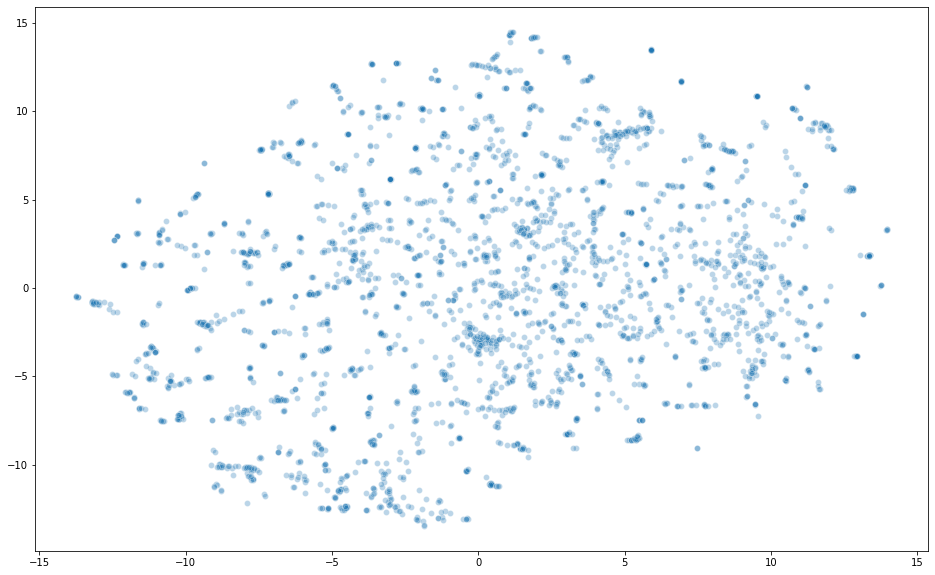

In [119]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [120]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [121]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [122]:
def similar_products(v, n = 20):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.similar_by_vector

In [123]:
similar_products(model['90019A'])

[('ANT COPPER RED BOUDICCA BRACELET', 0.8027130365371704),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.795428991317749),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7902275919914246),
 ('PINK HEART OF GLASS BRACELET', 0.7877365946769714),
 ('PINK BOUDICCA LARGE BRACELET', 0.7796621918678284),
 ('JADE DROP EARRINGS W FILIGREE', 0.7700693011283875),
 ('GREEN HEART OF GLASS BRACELET', 0.769608736038208),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.7667273879051208),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7664657831192017),
 ('BLUE MURANO TWIST BRACELET', 0.7586478590965271),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7490488290786743),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7436199188232422),
 ('SILVER M.O.P. ORBIT NECKLACE', 0.741837203502655),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.7382662892341614),
 ('CHUNKY SILVER NECKLACE PASTEL FLOWE', 0.7263173460960388),
 ('ANT COPPER PINK BOUDICCA BRACELET', 0.7257962822914124),
 ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.7208315134048462),
 ('AMETHYST

In [124]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [125]:
len(purchases_val[0])

251

In [126]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [127]:
similar_products(aggregate_vectors(purchases_val[1]))

[('CREAM HANGING HEART T-LIGHT HOLDER', 0.6443025469779968),
 ('JUMBO BAG RED RETROSPOT', 0.6433821320533752),
 ('RED RETROSPOT PICNIC BAG', 0.6418949365615845),
 ('REGENCY CAKESTAND 3 TIER', 0.6401326060295105),
 ('LUNCH BAG PINK POLKADOT', 0.6347408294677734),
 ('LUNCH BAG RED RETROSPOT', 0.6325812339782715),
 ('JUMBO BAG STRAWBERRY', 0.6226279735565186),
 ('SET/5 RED RETROSPOT LID GLASS BOWLS', 0.6215821504592896),
 ('JUMBO BAG PINK POLKADOT', 0.6211433410644531),
 ('LUNCH BAG CARS BLUE', 0.6177996397018433),
 ('JUMBO STORAGE BAG SKULLS', 0.6170250177383423),
 ('JUMBO BAG SCANDINAVIAN BLUE PAISLEY', 0.6159611940383911),
 ('PARTY BUNTING', 0.6136523485183716),
 ('JUMBO  BAG BAROQUE BLACK WHITE', 0.612481415271759),
 ('JUMBO STORAGE BAG SUKI', 0.6094474196434021),
 ('RECIPE BOX WITH METAL HEART', 0.6038536429405212),
 ('JUMBO BAG PINK VINTAGE PAISLEY', 0.6032012701034546),
 ('3 PINK HEN+CHICKS IN BASKET', 0.602940559387207),
 ('LUNCH BAG SUKI DESIGN ', 0.5992828607559204),
 ('POPCORN 

In [128]:
similar_products(aggregate_vectors(purchases_val[1][-10:]))

[('PARISIENNE KEY CABINET ', 0.6278308629989624),
 ('FRENCH ENAMEL CANDLEHOLDER', 0.6148355007171631),
 ('NATURAL SLATE HEART CHALKBOARD ', 0.6106332540512085),
 ('HANGING HEART JAR T-LIGHT HOLDER', 0.5881523489952087),
 ('LARGE BLUE PROVENCAL CERAMIC BALL', 0.5864306688308716),
 ('SMALL CERAMIC TOP STORAGE JAR ', 0.5805058479309082),
 ('IVORY KITCHEN SCALES', 0.5767730474472046),
 ('CANDLE HOLDER SILVER MADELINE', 0.5764188766479492),
 ('ENAMEL FLOWER JUG CREAM', 0.5750259160995483),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.5739715099334717),
 ('GLASS BON BON JAR', 0.5725133419036865),
 ('VINTAGE ZINC WATERING CAN SMALL', 0.5702625513076782),
 ('SET OF TEA COFFEE SUGAR TINS PANTRY', 0.5690006613731384),
 ('PARISIENNE SEWING BOX', 0.5664287805557251),
 ('BLUE DELPHINIUM ARTIFICIAL FLOWER', 0.5657728314399719),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.5650700330734253),
 ('SET OF 3 CONEY ISLAND OVAL BOXES', 0.5647963881492615),
 ('PARISIENNE JEWELLERY DRAWER ', 0.5632266402244568),
 ('C

In [129]:
similar_products(aggregate_vectors(purchases_val[1]))

[('CREAM HANGING HEART T-LIGHT HOLDER', 0.6443025469779968),
 ('JUMBO BAG RED RETROSPOT', 0.6433821320533752),
 ('RED RETROSPOT PICNIC BAG', 0.6418949365615845),
 ('REGENCY CAKESTAND 3 TIER', 0.6401326060295105),
 ('LUNCH BAG PINK POLKADOT', 0.6347408294677734),
 ('LUNCH BAG RED RETROSPOT', 0.6325812339782715),
 ('JUMBO BAG STRAWBERRY', 0.6226279735565186),
 ('SET/5 RED RETROSPOT LID GLASS BOWLS', 0.6215821504592896),
 ('JUMBO BAG PINK POLKADOT', 0.6211433410644531),
 ('LUNCH BAG CARS BLUE', 0.6177996397018433),
 ('JUMBO STORAGE BAG SKULLS', 0.6170250177383423),
 ('JUMBO BAG SCANDINAVIAN BLUE PAISLEY', 0.6159611940383911),
 ('PARTY BUNTING', 0.6136523485183716),
 ('JUMBO  BAG BAROQUE BLACK WHITE', 0.612481415271759),
 ('JUMBO STORAGE BAG SUKI', 0.6094474196434021),
 ('RECIPE BOX WITH METAL HEART', 0.6038536429405212),
 ('JUMBO BAG PINK VINTAGE PAISLEY', 0.6032012701034546),
 ('3 PINK HEN+CHICKS IN BASKET', 0.602940559387207),
 ('LUNCH BAG SUKI DESIGN ', 0.5992828607559204),
 ('POPCORN 